# Topic Clustering using Sentence Embeddings

In [1]:
path = '/home/piotr/projects/twitter'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pickle
import gc
import numpy as np
import pandas as pd
from itertools import chain
import re
import json
sys.path.append(os.path.join(path, 'src'))
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt
from nltk import FreqDist, word_tokenize
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()
path_data = os.path.join(path, 'data/clean/twitter_data.csv')
path_results = os.path.join(path, 'results/topics')

### Define topic modelling evaluation methods:

Tokens not appearing as most common in other topics:

In [3]:
def eval_topics(text, labels, n = 100):
    dists = dict()
    for i in np.unique(labels):
        txt = text[labels == i]
        freq = FreqDist(chain.from_iterable(txt))
        dists[i] = freq.most_common(n)
    dists_unique = dict()
    for i, dist in dists.items():
        #get vocabulary of all other topics but i
        rest = []
        _ = [rest.extend([el[0] for el in v]) for k, v in dists.items() if k != i]
        #filter out those not included in the vocabulary of topic i
        dists_unique[i] = {k:v for k, v in dist if k not in rest}
    return dists_unique

In [4]:
def clustering_summary(text, labels, source, **kwargs):
    dists = eval_topics(text, labels, **kwargs)
    dists_nocounts = {k:[", ".join(list(v))] for k, v in dists.items()}
    df =  pd.DataFrame.from_dict(dists_nocounts, orient = "index")
    sources = pd.crosstab(labels, source)
    df = pd.merge(df, sources, left_index = True, right_index = True)
    df["count"] = df[["gov","opp"]].sum(axis = 1)
    df.columns = ["tokens","gov","opp","count"]
    return df, dists

### K-Means Clustering of sentence embeddings, as defined in [A Simple But Though-to-Beat Baseline for Sentence Embbedings](https://openreview.net/pdf?id=SyK00v5xx)

In [5]:
res = json.load(open(os.path.join(path_results, 'params_search_results_.json'), 'r'))
pd.DataFrame(res)

,a,k,silhuette,intertia,2,3,0,1,4,entropy,...,11,19,12,13,17,10,16,14,18,15
0,0.0001,5,0.090408,1.513545e-08,840255,457675,452764,447608,395366,14.484023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0001,10,0.072426,1.177528e-08,94208,245539,199921,140386,314035,14.601151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0001,20,0.045157,9.127568e-09,103529,38477,58552,662679,69093,14.444697,...,214648.0,197810.0,168116.0,150955.0,106874.0,64513.0,55966.0,37317.0,36948.0,20679.0
3,0.0010,5,0.090218,1.514964e-06,448364,454354,334078,948859,408013,14.487423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0010,10,0.072791,1.150253e-06,343206,266111,226361,765649,136502,14.417888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0010,20,0.044371,9.289937e-07,61973,50342,133899,90802,40221,14.602825,...,152124.0,215290.0,97873.0,155214.0,82072.0,68938.0,97460.0,87056.0,157783.0,71919.0
6,0.0100,5,0.099126,1.493327e-04,930215,440155,383776,408773,430749,14.520211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0100,10,0.075608,1.142105e-04,110135,314713,231121,104151,125022,14.575834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0100,20,0.055120,8.804239e-05,44694,156640,202549,92236,158013,14.550410,...,60370.0,117598.0,49157.0,111057.0,231207.0,662047.0,38693.0,79781.0,57485.0,51358.0


Load the best clustering:

In [6]:
data = pd.read_csv(path_data, index_col = 0, dtype = str)
cls = json.load(open(os.path.join(path_results, 'cluster_k_20_a_0.0001.json'),'r'))
data["cluster"] = data["id_str"].map(cls)
data.dropna(subset = ["cluster"], inplace = True)
data.reset_index(inplace = True, drop = True)

In [7]:
df, dists = clustering_summary(data.lemmatized.astype(str).apply(lambda x: x.split()), 
                          data.cluster.astype(int),
                       data.source)

In [8]:
df

,tokens,gov,opp,count
0,,30018,28534,58552
1,"życzyć, bóg, pozdrawiać, brawo, dzięki, piękny...",365956,296723,662679
2,"chwila, liczba, tys",54892,48637,103529
3,"szansa, głos, siedzieć",19475,19002,38477
4,zwykły,36076,33017,69093
5,"dowód, wychodzić",23964,21551,45515
6,"wrażenie, kiedyś, słyszeć, przyznać",46842,44858,91700
7,,71626,67901,139527
8,"dopiero, zobaczyć, stary",127155,111853,239008
9,,46973,44789,91762


#### Distribution of the topics

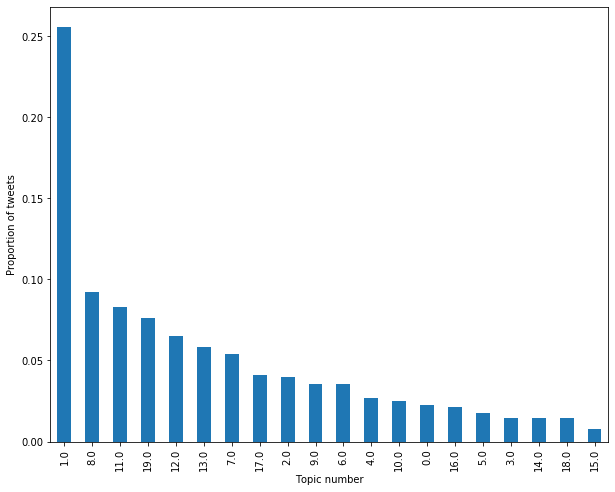

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
pd.value_counts(data.cluster, normalize = True).plot.bar(ax = ax)
ax.set_xlabel("Topic number")
ax.set_ylabel("Proportion of tweets")
plt.show()

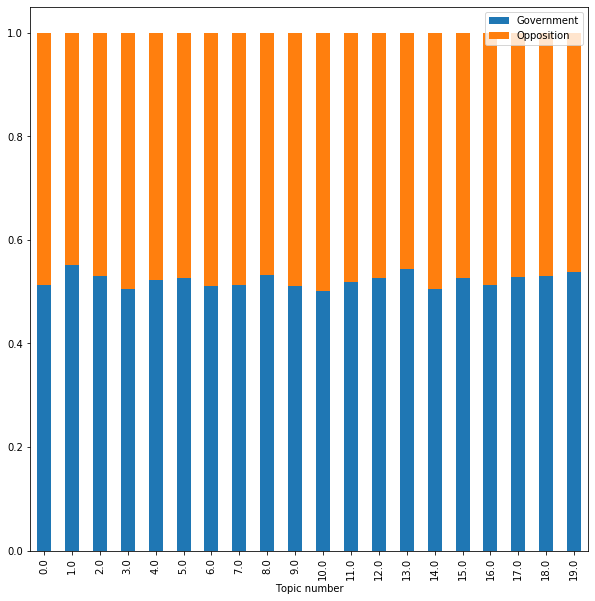

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
pd.crosstab(data.cluster, data.source, normalize = "index").plot.bar(ax = ax, stacked = True)
ax.set_xlabel("Topic number")
ax.legend(["Government", "Opposition"])
plt.show()

#### Most common "unique" tokens in each topic:

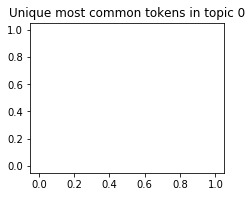

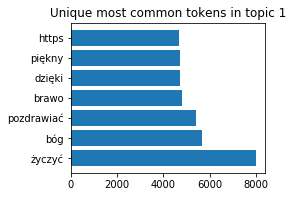

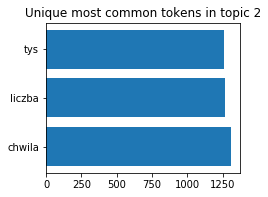

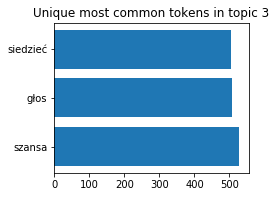

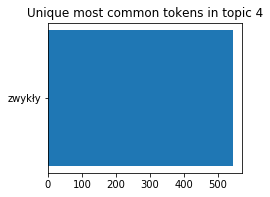

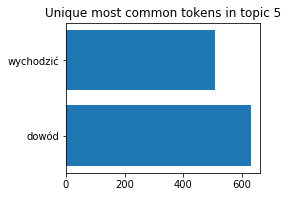

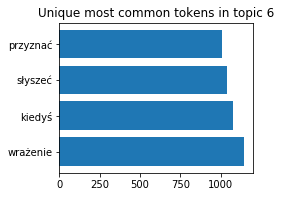

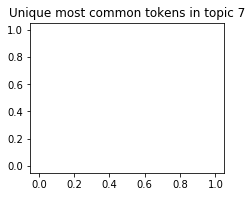

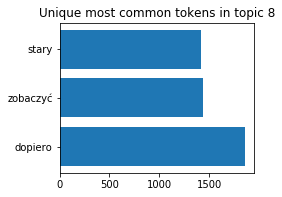

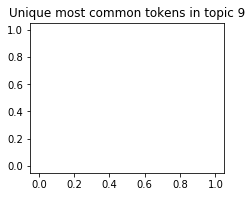

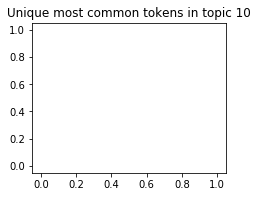

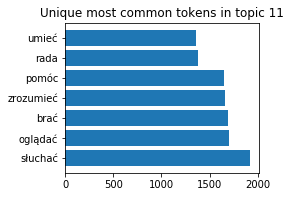

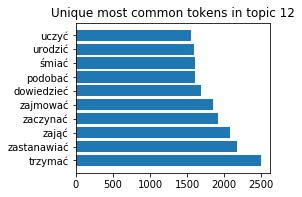

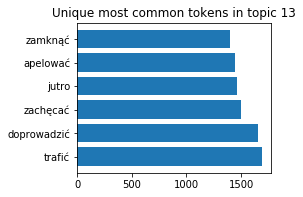

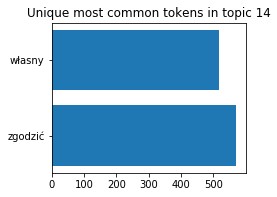

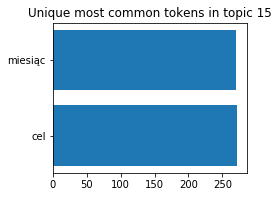

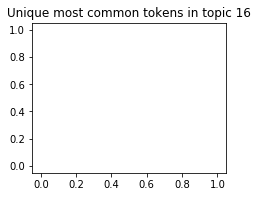

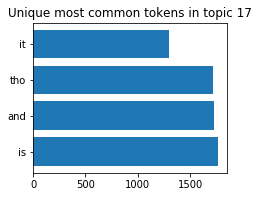

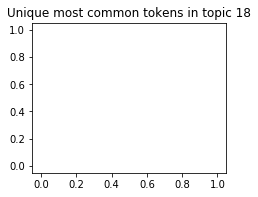

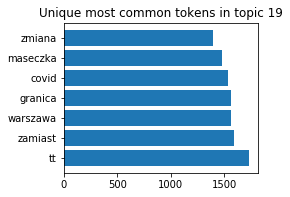

In [11]:
for i, (k, fdist) in enumerate(dists.items()):
    fig = plt.figure(figsize = (16, 16))
    ax = fig.add_subplot(5, 4, i + 1)
    ax.set_title(f"Unique most common tokens in topic {k}")
    ax.barh(y = list(fdist.keys())[:10], width = list(fdist.values())[:10])
plt.show()

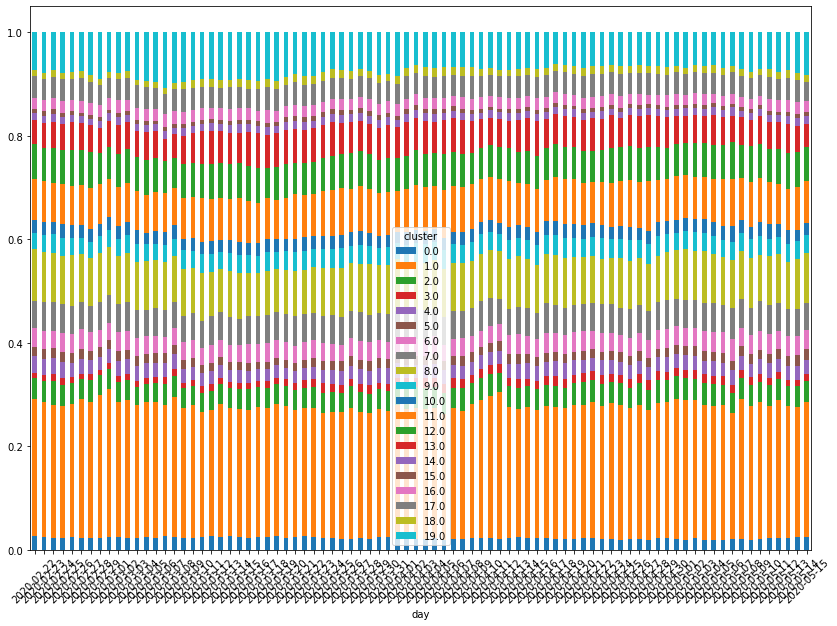

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (14,10))
pd.crosstab(data.day, data.cluster, normalize = "index").plot.bar(stacked = True, rot = 45, ax = ax)
plt.show()

In [28]:
data[data['cluster'] == 19.0].iloc[20000]

lemmatized     siebie śledzić radosny twórczość twitter nitra...
tokenized      tak sobie śledzę radosną twórczość na twitterz...
day                                                   2020-03-04
id_str                                       1235282692230582272
source                                                       gov
user-id_str                                           1444117237
retweet                                                     True
cluster                                                       19
Name: 253592, dtype: object